In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/

/content/drive


In [ ]:
cd MyDrive/

/content/drive/MyDrive


In [ ]:
cd Speech_Recognition_Deep Learning

/content/drive/MyDrive/Speech_Recognition_Deep Learning


In [ ]:
ls

'Speech_Recognition_Deep Learning.ipynb'


In [ ]:
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 14.7 MB/s eta 0:00:00


In [ ]:
# Importing libraries-
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

In [ ]:
# Importing LJSpeech Dataset-
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)

2748572632/2748572632 [==============================] - 47s 0us/step


In [ ]:
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

In [ ]:
# Reading and parsing the metadata-
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)

In [ ]:
metadata_df.head(10)

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
5,LJ001-0006,"And it is worth mention in passing that, as an...","And it is worth mention in passing that, as an..."
6,LJ001-0007,"the earliest book printed with movable types, ...","the earliest book printed with movable types, ..."
7,LJ001-0008,has never been surpassed.,has never been surpassed.
8,LJ001-0009,"Printing, then, for our purpose, may be consid...","Printing, then, for our purpose, may be consid..."
9,LJ001-0010,"Now, as all books not primarily intended as pi...","Now, as all books not primarily intended as pi..."


In [ ]:
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ034-0200,"Shortly after the assassination, Euins signed ..."
1,LJ020-0023,"If too stiff, warm water, a spoonful at a time..."
2,LJ028-0212,On the night of the eleventh day Gobrias kille...


In [ ]:
# Splitting the data into training and testing split-
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]    # Validation split

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 11790
Size of the training set: 1310


In [ ]:
# Data Preprocessing-

# the set of characters accepted in the transcription-
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping these characters to integers-
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping the integers back to the original characters-
num_to_char = keras.layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(), oov_token="", invert=True
    )

print(
    f"The Vocabulary is: {char_to_num.get_vocabulary()}"
    f"(size = {char_to_num.vocabulary_size()})"
)

The Vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '](size = 31)


In [ ]:
# Creating a function for Data Transformation-

# An integer scalar Tensor, the window length is in samples-
frame_length = 256
# An integer scalar Tensor, the number of samples to step-
frame_step = 160
# An integer scalar Tensor, the size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
  ## Process the audio-
  # Read the wav file-
  file = tf.io.read_file(wavs_path + wav_file + ".wav")
  # Decoding the wav file -
  audio, _ = tf.audio.decode_wav(file)
  audio = tf.squeeze(audio, axis=-1)
  # Changing type to float-
  audio = tf.cast(audio, tf.float32)
  # Getting the spectogram-
  spectogram = tf.signal.stft(
      audio, frame_length = frame_length, frame_step = frame_step, fft_length = fft_length
  )

  # Deriving magnitude-
  spectogram = tf.abs(spectogram)
  spectogram = tf.math.pow(spectogram, 0.5)

  #Normalisation -
  means = tf.math.reduce_mean(spectogram, 1, keepdims=True)
  stddevs = tf.math.reduce_std(spectogram, 1, keepdims=True)
  spectogram = (spectogram - means) / (stddevs + 1e-10)

  #Processing the label-
  ######################

  # Converting the label to lower case-
  label = tf.strings.lower(label)

  #Splitting the label-
  label = tf.strings.unicode_split(label, 'UTF-8')
  # Mapping the characters in label to numbers-
  label = char_to_num(label)
  # Returning a dict as our model is expecting two inputs-
  return spectogram, label


In [ ]:
# Creating Dataset objects
batch_size = 32

# Defining the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((list(df_train["file_name"]), list(df_train["normalized_transcription"])))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Defining the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices((list(df_val["file_name"]), list(df_val["normalized_transcription"])))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

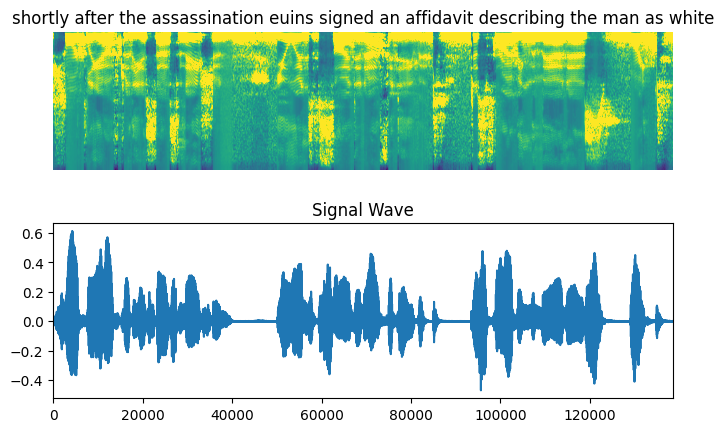

In [ ]:
# Visualising the data-
fig = plt.figure(figsize = (8,5))
for batch in train_dataset.take(1):
  spectogram = batch[0][0].numpy()
  spectogram = np.array([np.trim_zeros(x) for x in np.transpose(spectogram)])
  label = batch[1][0]

  #Spectogram-
  label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
  ax = plt.subplot(2, 1, 1)
  ax.imshow(spectogram, vmax=1)
  ax.set_title(label)
  ax.axis("off")

  # WAV-
  file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
  audio, _ = tf.audio.decode_wav(file)
  audio = audio.numpy()
  ax = plt.subplot(2, 1, 2)
  plt.plot(audio)
  ax.set_title("Signal Wave")
  ax.set_xlim(0, len(audio))
  display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [ ]:
# Building the Model-

# Defining the CTCLoss function-
def CTCLoss(y_true, y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
  input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
  label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")


  input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

  loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss

In [ ]:
# Defining the Model-
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    # Model's input-
    input_spectogram = layers.Input((None, input_dim), name="Input")
    x = layers.Reshape((-1, 1, input_dim))(input_spectogram)

    x = layers.Conv2D(
        filters=32,
        kernel_size=[11,41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name = "conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)

    # Convolution Layer 2-
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11,21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)

    # Reshaping the resulted volume to maintain 3D shape-
    x = layers.Reshape((-1, x.shape[2] * x.shape[3]))(x)

    # RNN Layers-
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units = rnn_units,
            activation = "tanh",
            recurrent_activation = "sigmoid",
            use_bias = True,
            return_sequences = True,
            reset_after = True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)

    # Dense Layer-
    x = layers.Dense(units = rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)

    # Classification Layer-
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

    # Model-
    model = keras.Model(input_spectogram, output, name="DeepSpeech_2")

    # Optimizer-
    opt = keras.optimizers.Adam(learning_rate=1e-4)

    # Compiling the model-
    model.compile(optimizer=opt, loss=CTCLoss)
    return model

# Getting the Model-
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512
)
model.summary(line_length=110)


Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 Input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 reshape_18 (Reshape)                            (None, None, 1, 193)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 1, 32)                         2785376          
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 1, 32)                      

In [ ]:
# Training and Evaluation-
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Using Greedy Search-
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterating and obtaining result-
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


class CallbackEval(keras.callbacks.Callback):
    # Displaying a bunch of outputs after every epoch-
    def __init__(self,dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
      predictions = []
      targets = []
      for batch in self.dataset:
        X, y = batch
        batch_predictions = model.predict(X)
        batch_predictions = decode_batch_predictions(batch_predictions)
        predictions.extend(batch_predictions)
        for label in y:
          label = (
              tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
          )
          targets.append(label)
      wer_score = wer(targets, predictions)
      print("-" * 100)
      print(f"Word Error Rate: {wer_score:.4f}")
      print("-" * 100)
      for i in np.random.randint(0, len(predictions), 2):
          print(f"Target    :  {targets[i]}")
          print(f"Prediction:  {predictions[i]}")
          print("-" * 100)

In [ ]:
# Define a checkpoint manager
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(model=model, optimizer=model.optimizer)
epochs = 2
# Training loop
num_epochs = 100  # Replace with the desired number of epochs

for epoch in range(num_epochs):
    history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

# Save checkpoint every 5 epochs
if epoch % 5 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)
    print(f'Checkpoint saved at {checkpoint_prefix}')

# Load the latest checkpoint before resuming training
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print(f'Checkpoint loaded from {latest_checkpoint}')
else:
    print('No checkpoint found.')

In [ ]:
# Training the model-
epochs = 2

# Callback Function to check transcription on Validation Set-
validation_callback = CallbackEval(validation_dataset)
# Training the Model-
history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

In [ ]:
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction    : {predictions[i]}")
    print("-" * 100)
